In [25]:
# just spend an hour fixing a problem that didn't exist. All because Jan 1 2033 is a weekend... love bdays
#
# INFO:
#
# All the bank loan amort calcs I found rounded the interest payment amount, and then calculate the total payyment 
#  based on the total interest (after rounding) + the principal
#
# TO FIX:
# *code breaks at term_year > 75 because of the turn of the century 
#
# **** Most dates do not work, like any day larger than 4 or 5... problem is related to month_dates
#
# *** "M-Actual" all arrays must be same length. might be related to month_dates somehow
#
# TO ADD:
# A pie graph that shows total amount paid in interest vs pricipal
#
# add a folder for the imported functions and change the import path
#
# add bar graph monthly payment distribution
#
#

import os
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pandas as pd
import calendar
from statistics import mean
import seaborn as sns
import matplotlib.pyplot as plt

# functions created for this project (should create links if I ever share this)
from validate_date import validate_date
from business_days import business_days
from cumulative_values import cumulative_values


def loan_amortization(principal, interest_rate,  term_years, start_date, periodtype="M-30", bonus=0, PLOT=False):
    
    """ 
    Args:
        principal (int or float): The principal amount of the loan.
        interest_rate (int or float): The annual interest rate, expressed as a percent (e.g. 5% = 5).
        term_years (int or float): Loan/Borrowing term in years.
        start_date (str or datetime): The start date of the loan as a string in 'YYYY-MM-DD' format or as a datetime object.
        periodtype (str, default="M-30"): The type of period to use for the loan payments, which can be one of the following:
            'D' (daily)
            'bdays' (daily, only includes business days)
            'W' (weekly)
            'BW' (biweekly)
            'M-30' (months where there is 30 days per month and 360 days per year (30/360))
            'M-Actual' (months where months' lengths are accurate, and there are 360 days per year (Actual/360))
            'Q' (quarterly)
            'S' (semi-annual)
            'Y' (Annual)
        bonus= (int or float, default=0): Optional, additional principal paid per period.
        PLOT= (Bool, default=False): With PLOT set to True, the function will create a folder in the cwd
                                    and download the loan amortization graph as a .png file.
                                - The .png file will have the following naming structure:
                                    - /Loan_Graphs/'Principal_Rate_TermYears_StartDate_PeriodType_bonus.png'
    Returns:
        pandas.DataFrame: A DataFrame containing the amortization schedule for the loan
    """

    if validate_date(start_date) == False:
        raise TypeError("start_date must be a string in 'YYYY-MM-DD' format or a datetime object")
    
    # if the date is in the string format, convert it
    if not isinstance(start_date, datetime):
        start_date = datetime.strptime(start_date, '%Y-%m-%d')
    
    # input type checking for principal, interest_rate, term_years, and bonus
    if not isinstance(principal, (int, float)):
        raise TypeError("Principal amount should be numeric (int or float)")
    if not isinstance(interest_rate, (int, float)):
        raise TypeError("Interest rate should be numeric and in % (int or float)")
    if not isinstance(term_years, (int, float)):
        raise TypeError("term_years should be numeric (int or float)")
    if not isinstance(bonus, (int, float)):
        raise TypeError("bonus should be numeric (int or float)")
    if bonus < 0:
        raise TypeError("bonus should be a positive integer")
    
    # shift the day forward one when using Daily to assume no payment is made today
    if periodtype == "D":
        start_date = start_date + timedelta(days=1)
    
    # create end date of term using term_years
    end_date = start_date + timedelta(days=int(365.2422 * term_years))
    
    # create a list of business days for the bday index
    bdays_dates = business_days(start_date, end_date)
    
    # create a list of weeks for weekly and biweekly index, starting at second week
    week_range = pd.date_range(start=start_date + pd.Timedelta(weeks=1) + pd.Timedelta(days=1), periods=52*term_years, freq='W')
    week_list = [f'{date.week}-{date.year}' for date in week_range]
    
    # force start_date to first day of month for month indexing
    start_date_first = datetime(start_date.year, start_date.month, 1)
    if start_date_first.month == 12:
        # handle special case where the month is December
        new_month = 1
        new_year = start_date_first.year + 1
    else:
        new_month = start_date_first.month + 1
        new_year = start_date_first.year
    start_date_p1 = start_date_first.replace(year=new_year, month=new_month)
    # create month_dates index
    month_dates = [start_date_p1.strftime("%m""-""%Y")]
    month_dates_4D = [start_date_p1]
    current_date = start_date_p1
    while current_date < end_date:
        current_date += relativedelta(months=1)
        month_dates_4D.append(current_date)
        month_dates.append(current_date.strftime("%m""-""%Y"))
    # create list of days in the month of each date
    days_in_month = [calendar.monthrange(date.year, date.month)[1] for date in month_dates_4D]

    # period-type definition
    if periodtype == 'D':
        periods = int((end_date - start_date).days)
        adjusted_rate = interest_rate / 36525
    elif periodtype == 'bdays':
        periods = len(bdays_dates)
        adjusted_rate = interest_rate / 26100
    elif periodtype == 'W':
        periods = int(52 * term_years)
        adjusted_rate = interest_rate / 5200
    elif periodtype == 'BW':
        periods = int((52 * term_years) / 2)
        adjusted_rate = interest_rate / 2600
    elif periodtype == 'M-30':
        periods = int(12 * term_years)
        adjusted_rate = interest_rate / 1200
    elif periodtype == 'M-Actual':
        periods = int(12 * term_years)
        monthly_rate = [interest_rate / 36000 * days_in_month[i] for i in range(len(month_dates))]
        adjusted_rate = mean(monthly_rate)
    elif periodtype == 'Y':
        periods = int(end_date.year - start_date.year) + 1
        adjusted_rate = interest_rate / 100
    elif periodtype == 'S':
        periods = int(len(month_dates[1::6]))
        adjusted_rate = interest_rate / 200
    elif periodtype == 'Q':
        periods = int(len(month_dates[1::3]))
        adjusted_rate = interest_rate / 400
    else:
        raise TypeError("periodtype should be one of the following: 'D', 'W', 'BW', 'bdays', 'M-30', 'M-Actual', 'Q', 'S', 'Y'")

    # find payment amount
    monthly_payment = (principal * adjusted_rate / (1 - (1 + adjusted_rate) ** (-periods)))
    monthly_payment_fmt = "{:,.2f}".format(monthly_payment)
    actual_payment = (principal * adjusted_rate / (1 - (1 + adjusted_rate) ** (-periods))) + bonus
    
    # create a list of dates for each payment
    if periodtype == 'M-Actual' or periodtype == 'M-30':
        payment_dates = month_dates
    elif periodtype == 'Y':
        payment_dates = [(start_date + relativedelta(years=1 * i)).year for i in range(periods)]
    elif periodtype == 'bdays':
        payment_dates = bdays_dates
    elif periodtype == 'W':
        payment_dates = week_list
    elif periodtype == 'BW':
        payment_dates = week_list[::2]
    elif periodtype == 'S':
        month_dates.insert(0, start_date.strftime("%m""-""%Y"))
        payment_dates = month_dates[:-6:6]
    elif periodtype == 'Q':
        payment_dates = month_dates[1::3]
    else:
        payment_dates = [start_date + relativedelta(days=(i)) for i in range(periods)]

    # lists for the payment number, payment amount, interest, principal, and balance
    payment_number = list(range(1, periods + 1))
    payment_amount = [actual_payment] * periods
    interest = []
    principal_paid = []
    beg_balance = [principal]
    end_balance = []
    pct_interest = []
    pct_principal = []
    bonus_list = [bonus] * periods

    # interest, principal, and balance for each payment period (exlcuding M-actual)
    if not periodtype == "M-Actual":
        for i in range(periods):
            interest.append(beg_balance[i] * adjusted_rate)
            principal_paid.append((monthly_payment) - interest[i])
            beg_balance.append(beg_balance[i] - principal_paid[i] - bonus)
            end_balance.append(beg_balance[i] - principal_paid[i] - bonus)
            pct_interest.append((interest[i] / payment_amount[i]) * 100)
            pct_principal.append((principal_paid[i] / payment_amount[i]) * 100)
    elif periodtype == "M-Actual":
        for i in range(periods):
            interest.append((beg_balance[i] * monthly_rate[i]))
            principal_paid.append((monthly_payment) - interest[i])
            beg_balance.append(beg_balance[i] - principal_paid[i] - bonus)
            end_balance.append(beg_balance[i] - principal_paid[i] - bonus)
            pct_interest.append((interest[i] / payment_amount[i]) * 100)
            pct_principal.append((principal_paid[i] / payment_amount[i]) * 100)
        principal_paid[-1] = beg_balance[-2]
        payment_amount[-1] = principal_paid[-1] + interest[-1]
        end_balance[-1] = 0

    # if bonus > 0: do fake amortization without bonus for calc of interest saved
    if bonus > 0:
        interest2 = []
        principal_paid2 = []
        beg_balance2 = [principal]
        end_balance2 = []
        if not periodtype == "M-Actual":
            for i in range(periods):
                interest2.append(beg_balance2[i] * adjusted_rate)
                principal_paid2.append((monthly_payment) - interest2[i])
                beg_balance2.append(beg_balance2[i] - principal_paid2[i])
                end_balance2.append(beg_balance2[i] - principal_paid2[i])
        elif periodtype == "M-Actual":
            for i in range(periods):
                interest2.append((beg_balance2[i] * monthly_rate[i]))
                principal_paid2.append((monthly_payment) - interest2[i])
                beg_balance2.append(beg_balance2[i] - principal_paid2[i])
                end_balance2.append(beg_balance2[i] - principal_paid2[i])
        
    # make the amortization-schedule dataframe
    data = {
        'Payment Number': payment_number,
        'Payment Date': payment_dates,
        'Beginning Balance': beg_balance[:-1],
        'Payment Amount': payment_amount,
        'Bonus': bonus_list,
        'Interest Paid': interest,
        'Principal Paid': principal_paid,
        'Ending Balance': end_balance,
        '% Paid In Interest': pct_interest,
        '% Paid To Principal': pct_principal
    }
    # dataframe creation
    df = pd.DataFrame(data)
    
    # truncate df with bonus
    if bonus > 0:
        index_balance = (df['Ending Balance'] <= 0).idxmax()
        df = df.iloc[:index_balance + 1]
        df["Principal Paid"].iloc[-1] = df["Beginning Balance"].iloc[-1]
        df["Payment Amount"].iloc[-1] = df["Principal Paid"].iloc[-1] + df["Interest Paid"].iloc[-1]
        if df["Ending Balance"].iloc[-2] <= 100:
            df["Bonus"].iloc[-1] = 0
        df["Ending Balance"].iloc[-1] = 0
        periods_b4save = periods
        periods = int(len(df.index))
        # find amount saved by extra payment ****
        amount_saved_nfmt = sum(interest2) - df["Interest Paid"].sum()
        amount_saved = "{:,.2f}".format(amount_saved_nfmt)
        # find periods saved
        periods_saved = periods_b4save - periods

    # create stats for plot
    # create total interest ****
    total_interest_nfmt = df["Interest Paid"].sum()
    total_interest = "{:,.2f}".format(total_interest_nfmt)

    # create total payment
    total_payment_nfmt = total_interest_nfmt + principal
    total_payment = "{:,.2f}".format(total_payment_nfmt)
    
    # set index to dates
    df.set_index('Payment Date', inplace=True)
    if periodtype == "M-Actual" or periodtype == "M-30" or periodtype == "Q" or periodtype == "S":
        df.index.name = "Payment Month"
    elif periodtype == "W" or periodtype == "BW":
        df.index.name = "Payment Week"
    elif periodtype == "Y":
        df.index.name = "Payment Year"
    else:
        df.index.name = 'Payment Date'

    # apply formating for dollar signs and two decimals (new df to retain old format)
    df['Payment Amount'] = df['Payment Amount'].apply(lambda x: '${:,.2f}'.format(x))
    df['Interest Paid'] = df['Interest Paid'].apply(lambda x: '${:,.2f}'.format(x))
    df['Principal Paid'] = df['Principal Paid'].apply(lambda x: '${:,.2f}'.format(x))
    df['Beginning Balance'] = df['Beginning Balance'].apply(lambda x: '${:,.2f}'.format(x))
    df['Ending Balance'] = df['Ending Balance'].apply(lambda x: '${:,.2f}'.format(x))
    df['% Paid In Interest'] = df['% Paid In Interest'].apply(lambda x: '{:,.3f}%'.format(x))
    df['% Paid To Principal'] = df['% Paid To Principal'].apply(lambda x: '{:,.3f}%'.format(x))

    # format data for graph
    if bonus > 0:
        start_value = 0
        loan_balance_bonus = end_balance.copy()
        loan_balance = loan_balance_bonus[:index_balance+1]
        loan_balance.insert(0, principal)
        cumulative_interest_list = cumulative_values(interest)
        cumulative_interest_bonus = cumulative_interest_list.copy()
        cumulative_interest = cumulative_interest_bonus[:index_balance+1]
        cumulative_interest.insert(0, start_value)
        principal_paid_plot = [x + bonus if i < len(principal_paid)-1 else x for i, x in enumerate(principal_paid)] 
        cumulative_principal_list = cumulative_values(principal_paid_plot)
        cumulative_principal_bonus = cumulative_principal_list.copy()
        cumulative_principal = cumulative_principal_bonus[:index_balance+1]
        cumulative_principal.insert(0, start_value)
    else:
        start_value = 0
        loan_balance = end_balance.copy()
        loan_balance.insert(0, principal)
        cumulative_interest_list = cumulative_values(interest)
        cumulative_interest = cumulative_interest_list.copy()
        cumulative_interest.insert(0, start_value)
        cumulative_principal_list = cumulative_values(principal_paid)
        cumulative_principal = cumulative_principal_list.copy()
        cumulative_principal.insert(0, start_value)
    plot_data = {
        'Loan Balance': loan_balance,
        'Cumulative Interest': cumulative_interest,
        'Principal Paid': cumulative_principal
    }
    
    # make plot if one does not exists in the graphs folder
    plot = sns.lineplot(data=plot_data)
    
    # tweak visual aspects of plot
    plot.set_title(f"Loan Amortization Graph ({periodtype})")
    plot.set_xlabel("Payment Number")
    plot.set_ylabel("Amount (in Dollars)")
    plt.grid(True)
    
    # change line color
    lines = plot.lines
    lines[0].set(color='blue', linestyle='-')
    lines[1].set(color='red', linestyle='-')
    lines[2].set(color='green', linestyle='-')
    
    # make sure legend matches line color
    ax = plot.axes
    handles, labels = ax.get_legend_handles_labels()
    handles[0].set(color='blue', linestyle='-')
    handles[1].set(color='red', linestyle='-')
    handles[2].set(color='green', linestyle='-')
    ax.legend(handles=handles, labels=labels)
    
    # add the total stats as annotations
    plt.annotate(f'Total Cost of Loan: ${total_payment}', xy=((periods * .3), (principal)), xytext=((periods * .269), principal), bbox=dict(facecolor='white', boxstyle='round'))
    plt.annotate(f'Total Interest Paid: ${total_interest}', xy=((periods * .3), (principal)), xytext=((periods * .27), (principal - (principal * .075))), bbox=dict(facecolor='white', boxstyle='round'))
    plt.annotate(f'Monthly Payment: ${monthly_payment_fmt}', xy=((periods * .3), (principal)), xytext=((periods * .31), (principal - (principal * .15))), bbox=dict(facecolor='white', boxstyle='round'))

    # add addition annotations if there is bonus
    if bonus > 0:
        plt.annotate(f'Interest Saved w/ Bonus: ${amount_saved}', xy=((periods * .3), (principal)), xytext=(0 - (periods * .075) , (principal * 1.15)), bbox=dict(facecolor='white', boxstyle='round'))
        plt.annotate(f'Periods Saved w/ Bonus: {periods_saved}', xy=((periods * .3), (principal)), xytext=(periods - (periods * .4) , (principal * 1.15)), bbox=dict(facecolor='white', boxstyle='round'))
    # save plot to graphs folder if PLOT=True
    if PLOT is True:
        if not os.path.exists('loan_graphs'):
            os.makedirs('loan_graphs')
        # save plot with filename based on input parameters
        plot_filename = f"loan_graphs/{principal}_{interest_rate}_{term_years}_{start_date.date()}_{periodtype}_bonus{bonus}.png"
        if not os.path.isfile(plot_filename):  # ensure plot doesn't attmept to save twice
            plt.savefig(plot_filename)

    return df

In [20]:
start_date = datetime(2023,1,29)
start_date_first = datetime(start_date.year, start_date.month, 1)
start_date_first

datetime.datetime(2023, 1, 1, 0, 0)

,Payment Number,Beginning Balance,Payment Amount,Bonus,Interest Paid,Principal Paid,Ending Balance,% Paid In Interest,% Paid To Principal
Payment Month,,,,,,,,,
02-2023,1,"$200,000.00","$1,370.41",500,$541.67,$328.75,"$199,171.25",39.526%,23.989%
03-2023,2,"$199,171.25","$1,370.41",500,$539.42,$330.99,"$198,340.26",39.362%,24.153%
04-2023,3,"$198,340.26","$1,370.41",500,$537.17,$333.24,"$197,507.02",39.198%,24.317%
05-2023,4,"$197,507.02","$1,370.41",500,$534.91,$335.50,"$196,671.52",39.033%,24.482%
06-2023,5,"$196,671.52","$1,370.41",500,$532.65,$337.76,"$195,833.76",38.868%,24.647%
...,...,...,...,...,...,...,...,...,...
03-2038,182,"$6,739.04","$1,370.41",500,$18.25,$852.16,"$5,386.88",1.332%,62.183%
04-2038,183,"$5,386.88","$1,370.41",500,$14.59,$855.82,"$4,031.06",1.065%,62.450%
05-2038,184,"$4,031.06","$1,370.41",500,$10.92,$859.50,"$2,671.56",0.797%,62.718%


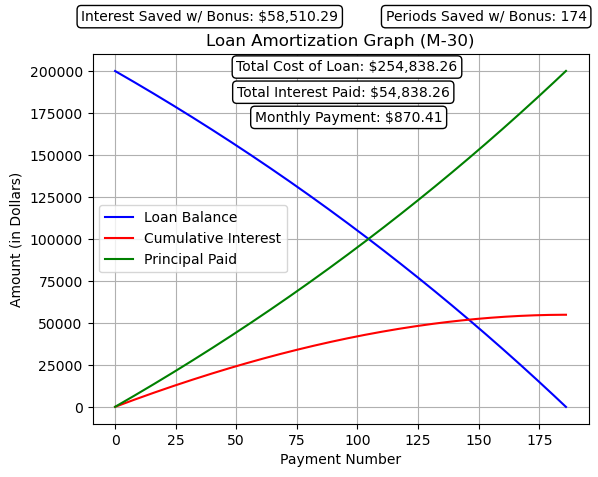

In [28]:
schedule = loan_amortization(200000, 3.25, 30, "2023-1-1", bonus=500, PLOT=True)

schedule

,Payment Number,Beginning Balance,Payment Amount,Bonus,Interest Paid,Principal Paid,Ending Balance,% Paid In Interest,% Paid To Principal
Payment Date,,,,,,,,,
2023-01-02,1,"$200,000.00",$55.37,0,$32.85,$22.52,"$199,977.48",59.335%,40.665%
2023-01-03,2,"$199,977.48",$55.37,0,$32.85,$22.52,"$199,954.96",59.328%,40.672%
2023-01-04,3,"$199,954.96",$55.37,0,$32.85,$22.52,"$199,932.44",59.322%,40.678%
2023-01-05,4,"$199,932.44",$55.37,0,$32.84,$22.53,"$199,909.91",59.315%,40.685%
2023-01-06,5,"$199,909.91",$55.37,0,$32.84,$22.53,"$199,887.38",59.308%,40.692%
...,...,...,...,...,...,...,...,...,...
2037-12-27,5474,$276.72,$55.37,0,$0.05,$55.33,$221.39,0.082%,99.918%
2037-12-28,5475,$221.39,$55.37,0,$0.04,$55.33,$166.06,0.066%,99.934%
2037-12-29,5476,$166.06,$55.37,0,$0.03,$55.34,$110.71,0.049%,99.951%


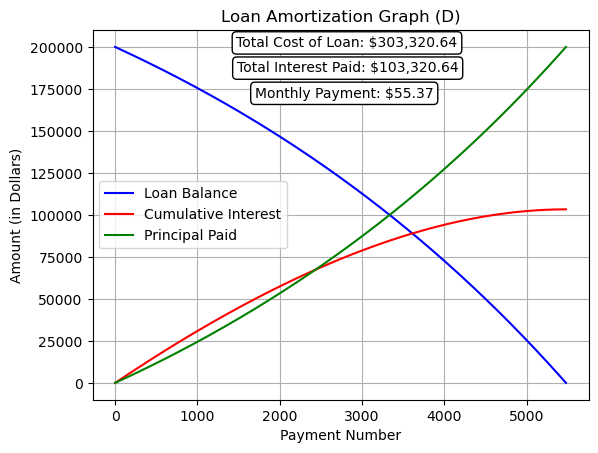

In [3]:
schedule = loan_amortization(200000, 6, 15, "2023-1-1", 'D', PLOT=True)

schedule

,Payment Number,Beginning Balance,Payment Amount,Bonus,Interest Paid,Principal Paid,Ending Balance,% Paid In Interest,% Paid To Principal
Payment Date,,,,,,,,,
2023-01-02,1,"$200,000.00",$101.91,0,$45.98,$55.93,"$199,944.07",45.115%,54.885%
2023-01-03,2,"$199,944.07",$101.91,0,$45.96,$55.95,"$199,888.12",45.102%,54.898%
2023-01-04,3,"$199,888.12",$101.91,0,$45.95,$55.96,"$199,832.16",45.090%,54.910%
2023-01-05,4,"$199,832.16",$101.91,0,$45.94,$55.97,"$199,776.19",45.077%,54.923%
2023-01-06,5,"$199,776.19",$101.91,0,$45.93,$55.99,"$199,720.20",45.065%,54.935%
...,...,...,...,...,...,...,...,...,...
2032-12-27,2606,$509.20,$101.91,0,$0.12,$101.79,$407.41,0.115%,99.885%
2032-12-28,2607,$407.41,$101.91,0,$0.09,$101.82,$305.59,0.092%,99.908%
2032-12-29,2608,$305.59,$101.91,0,$0.07,$101.84,$203.75,0.069%,99.931%


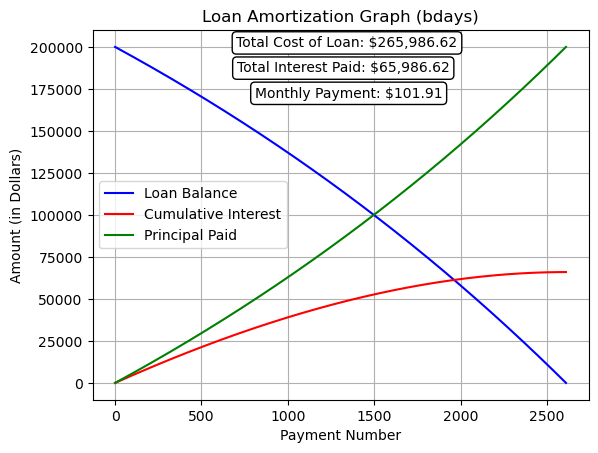

In [4]:
schedule = loan_amortization(200000, 6, 10, "2023-1-1", 'bdays')

schedule

,Payment Number,Beginning Balance,Payment Amount,Bonus,Interest Paid,Principal Paid,Ending Balance,% Paid In Interest,% Paid To Principal
Payment Week,,,,,,,,,
2-2023,1,"$200,000.00",$511.69,0,$230.77,$280.92,"$199,719.08",45.100%,54.900%
3-2023,2,"$199,719.08",$511.69,0,$230.45,$281.24,"$199,437.84",45.037%,54.963%
4-2023,3,"$199,437.84",$511.69,0,$230.12,$281.56,"$199,156.28",44.973%,55.027%
5-2023,4,"$199,156.28",$511.69,0,$229.80,$281.89,"$198,874.39",44.910%,55.090%
6-2023,5,"$198,874.39",$511.69,0,$229.47,$282.21,"$198,592.18",44.846%,55.154%
...,...,...,...,...,...,...,...,...,...
48-2032,516,"$2,549.59",$511.69,0,$2.94,$508.74,"$2,040.85",0.575%,99.425%
49-2032,517,"$2,040.85",$511.69,0,$2.35,$509.33,"$1,531.52",0.460%,99.540%
50-2032,518,"$1,531.52",$511.69,0,$1.77,$509.92,"$1,021.60",0.345%,99.655%


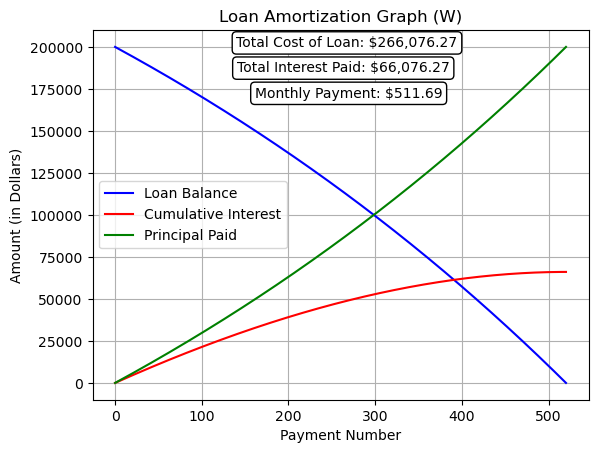

In [5]:
schedule = loan_amortization(200000, 6, 10, "2023-1-1", 'W')

schedule

,Payment Number,Beginning Balance,Payment Amount,Bonus,Interest Paid,Principal Paid,Ending Balance,% Paid In Interest,% Paid To Principal
Payment Week,,,,,,,,,
2-2023,1,"$200,000.00","$1,023.80",0,$461.54,$562.26,"$199,437.74",45.081%,54.919%
4-2023,2,"$199,437.74","$1,023.80",0,$460.24,$563.56,"$198,874.18",44.954%,55.046%
6-2023,3,"$198,874.18","$1,023.80",0,$458.94,$564.86,"$198,309.32",44.827%,55.173%
8-2023,4,"$198,309.32","$1,023.80",0,$457.64,$566.16,"$197,743.15",44.700%,55.300%
10-2023,5,"$197,743.15","$1,023.80",0,$456.33,$567.47,"$197,175.68",44.572%,55.428%
...,...,...,...,...,...,...,...,...,...
43-2032,256,"$5,083.75","$1,023.80",0,$11.73,"$1,012.07","$4,071.69",1.146%,98.854%
45-2032,257,"$4,071.69","$1,023.80",0,$9.40,"$1,014.40","$3,057.28",0.918%,99.082%
47-2032,258,"$3,057.28","$1,023.80",0,$7.06,"$1,016.75","$2,040.54",0.689%,99.311%


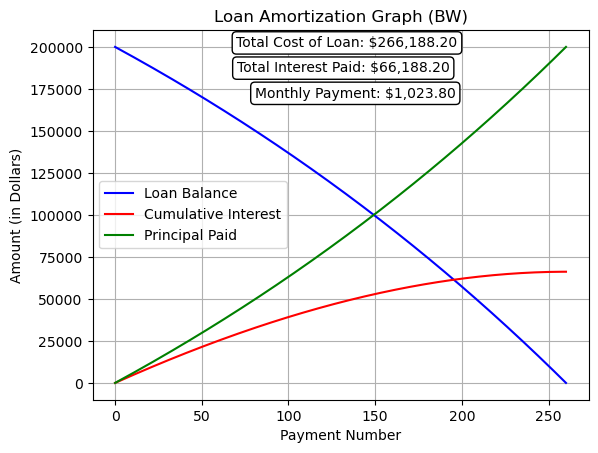

In [6]:
schedule = loan_amortization(200000, 6, 10, "2023-1-1", 'BW')

schedule

,Payment Number,Beginning Balance,Payment Amount,Bonus,Interest Paid,Principal Paid,Ending Balance,% Paid In Interest,% Paid To Principal
Payment Month,,,,,,,,,
03-2023,1,"$200,000.00","$6,685.42",0,"$3,000.00","$3,685.42","$196,314.58",44.874%,55.126%
06-2023,2,"$196,314.58","$6,685.42",0,"$2,944.72","$3,740.70","$192,573.88",44.047%,55.953%
09-2023,3,"$192,573.88","$6,685.42",0,"$2,888.61","$3,796.81","$188,777.07",43.208%,56.792%
12-2023,4,"$188,777.07","$6,685.42",0,"$2,831.66","$3,853.76","$184,923.30",42.356%,57.644%
03-2024,5,"$184,923.30","$6,685.42",0,"$2,773.85","$3,911.57","$181,011.73",41.491%,58.509%
06-2024,6,"$181,011.73","$6,685.42",0,"$2,715.18","$3,970.24","$177,041.49",40.613%,59.387%
09-2024,7,"$177,041.49","$6,685.42",0,"$2,655.62","$4,029.80","$173,011.69",39.723%,60.277%
12-2024,8,"$173,011.69","$6,685.42",0,"$2,595.18","$4,090.25","$168,921.44",38.818%,61.182%
03-2025,9,"$168,921.44","$6,685.42",0,"$2,533.82","$4,151.60","$164,769.84",37.901%,62.099%


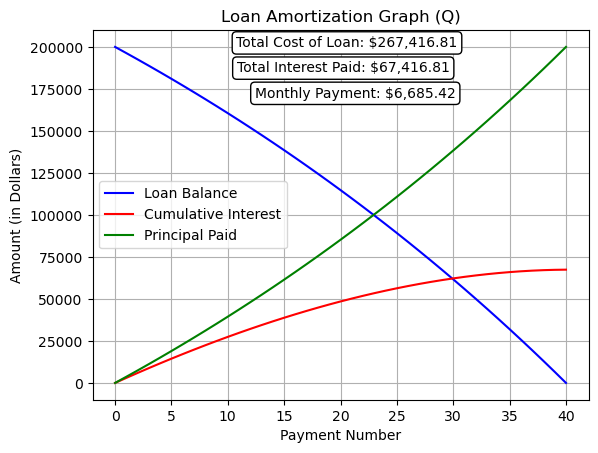

In [7]:
schedule = loan_amortization(200000, 6, 10, "2023-1-1", 'Q')

schedule

,Payment Number,Beginning Balance,Payment Amount,Bonus,Interest Paid,Principal Paid,Ending Balance,% Paid In Interest,% Paid To Principal
Payment Month,,,,,,,,,
01-2023,1,"$200,000.00","$13,443.14",0,"$6,000.00","$7,443.14","$192,556.86",44.632%,55.368%
07-2023,2,"$192,556.86","$13,443.14",0,"$5,776.71","$7,666.44","$184,890.42",42.971%,57.029%
01-2024,3,"$184,890.42","$13,443.14",0,"$5,546.71","$7,896.43","$176,993.99",41.261%,58.739%
07-2024,4,"$176,993.99","$13,443.14",0,"$5,309.82","$8,133.32","$168,860.67",39.498%,60.502%
01-2025,5,"$168,860.67","$13,443.14",0,"$5,065.82","$8,377.32","$160,483.35",37.683%,62.317%
07-2025,6,"$160,483.35","$13,443.14",0,"$4,814.50","$8,628.64","$151,854.71",35.814%,64.186%
01-2026,7,"$151,854.71","$13,443.14",0,"$4,555.64","$8,887.50","$142,967.21",33.888%,66.112%
07-2026,8,"$142,967.21","$13,443.14",0,"$4,289.02","$9,154.13","$133,813.08",31.905%,68.095%
01-2027,9,"$133,813.08","$13,443.14",0,"$4,014.39","$9,428.75","$124,384.34",29.862%,70.138%


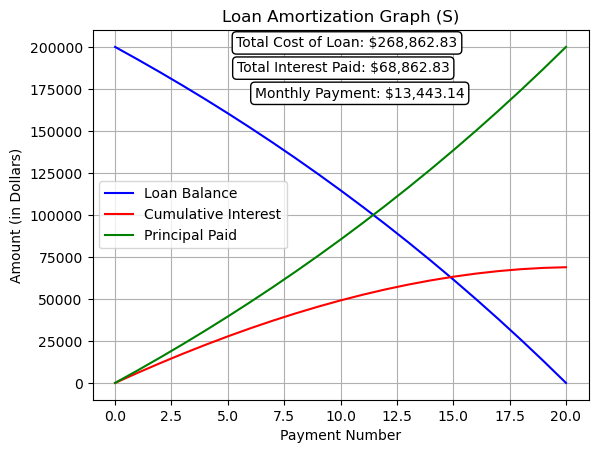

In [8]:
schedule = loan_amortization(200000, 6, 10, "2023-1-1", 'S')

schedule

,Payment Number,Beginning Balance,Payment Amount,Bonus,Interest Paid,Principal Paid,Ending Balance,% Paid In Interest,% Paid To Principal
Payment Year,,,,,,,,,
2023,1,"$200,000.00","$27,173.59",0,"$12,000.00","$15,173.59","$184,826.41",44.161%,55.839%
2024,2,"$184,826.41","$27,173.59",0,"$11,089.58","$16,084.01","$168,742.40",40.810%,59.190%
2025,3,"$168,742.40","$27,173.59",0,"$10,124.54","$17,049.05","$151,693.35",37.259%,62.741%
2026,4,"$151,693.35","$27,173.59",0,"$9,101.60","$18,071.99","$133,621.36",33.494%,66.506%
2027,5,"$133,621.36","$27,173.59",0,"$8,017.28","$19,156.31","$114,465.05",29.504%,70.496%
2028,6,"$114,465.05","$27,173.59",0,"$6,867.90","$20,305.69","$94,159.36",25.274%,74.726%
2029,7,"$94,159.36","$27,173.59",0,"$5,649.56","$21,524.03","$72,635.34",20.791%,79.209%
2030,8,"$72,635.34","$27,173.59",0,"$4,358.12","$22,815.47","$49,819.86",16.038%,83.962%
2031,9,"$49,819.86","$27,173.59",0,"$2,989.19","$24,184.40","$25,635.46",11.000%,89.000%


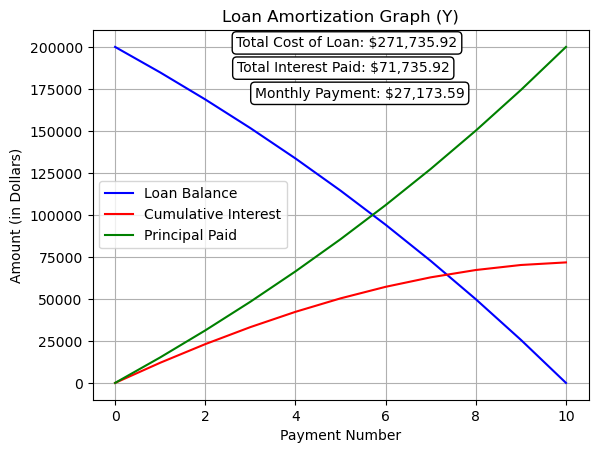

In [9]:
schedule = loan_amortization(200000, 6, 10, "2023-1-1", 'Y')

schedule

,Payment Number,Beginning Balance,Payment Amount,Bonus,Interest Paid,Principal Paid,Ending Balance,% Paid In Interest,% Paid To Principal
Payment Month,,,,,,,,,
02-2023,1,"$200,000.00",$898.09,0,$583.33,$314.76,"$199,685.24",64.953%,35.047%
03-2023,2,"$199,685.24",$898.09,0,$582.42,$315.67,"$199,369.57",64.850%,35.150%
04-2023,3,"$199,369.57",$898.09,0,$581.49,$316.59,"$199,052.98",64.748%,35.252%
05-2023,4,"$199,052.98",$898.09,0,$580.57,$317.52,"$198,735.46",64.645%,35.355%
06-2023,5,"$198,735.46",$898.09,0,$579.65,$318.44,"$198,417.01",64.542%,35.458%
...,...,...,...,...,...,...,...,...,...
09-2052,356,"$4,451.42",$898.09,0,$12.98,$885.11,"$3,566.32",1.446%,98.554%
10-2052,357,"$3,566.32",$898.09,0,$10.40,$887.69,"$2,678.63",1.158%,98.842%
11-2052,358,"$2,678.63",$898.09,0,$7.81,$890.28,"$1,788.35",0.870%,99.130%


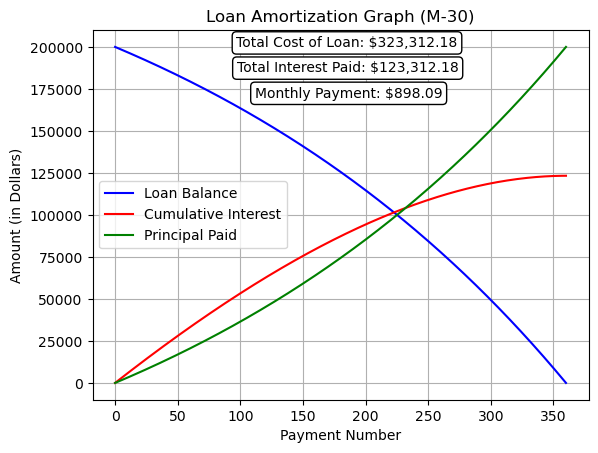

In [10]:
schedule = loan_amortization(200000, 3.5, 30, "2023-1-1", 'M-30')

schedule

In [26]:
schedule = loan_amortization(200000, 3.5, 30, "2023-1-28", 'M-Actual')

schedule

ValueError: All arrays must be of the same length

In [ ]:
schedule = loan_amortization(200000, 3.5, 30, "2023-1-1", 'M-Actual')

schedule